In [1]:
import tensorflow as tf 
import numpy as np 
import pickle
import numpy.random as rng
import matplotlib.pyplot as plt
from scipy.signal import lfilter

C:\Users\prash\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
fo=open('E:\Brain Machine\Code\cifar-10-python\cifar-10-batches-py\data_batch_1','rb')
dict=pickle.load(fo,encoding='bytes')
X=dict[b'data']
Y=dict[b'labels']
fo.close
X=X.reshape((len(X),3,32,32)).transpose(0,2,3,1).astype("uint8")
Y=np.array(Y)

In [3]:
def forward_conv(weights,input):
    return(tf.nn.conv2d(input,weights,strides=[1,1,1,1],padding="SAME"))

def forward_pooling_layer(inp):
    return(tf.nn.max_pool(value=inp,ksize=[1,2,2,1],strides=[1,1,1,1],padding="SAME"))

def flatten_forward(layer):
    inp_list=layer.get_shape().as_list()
    new_size = inp_list[-1] * inp_list[-2] * inp_list[-3]
    return tf.reshape(layer,[-1,new_size]),new_size

def fc_forward(layer,weights):
    return tf.matmul(layer,weights)

def activation(layer):
    return tf.nn.relu(layer)

In [4]:
filter_random = tf.Variable(rng.randn(2,2,3,3), dtype = tf.float32)

@tf.RegisterGradient("CustomConv")
def _conv2d(op,grad):
    print("in override backprop")
    input = op.inputs[0]
    filter = op.inputs[1]
    in_shape = tf.shape(input)
    f_shape = tf.shape(filter)
    g_input = tf.nn.conv2d_backprop_input(input_sizes = in_shape, filter = filter_random, out_backprop = grad, strides = [1,1,1,1], padding = "SAME")
    g_filter = tf.nn.conv2d_backprop_filter(input, filter_sizes = f_shape, out_backprop = grad, strides = [1,1,1,1], padding = "SAME")
    return g_input, g_filter



# Forward pass

In [5]:
batch=100
iterations=10000

In [6]:
filter_conv=tf.Variable(rng.randn(2,2,3,3), dtype = tf.float32) #constant
images=tf.placeholder(tf.float32,shape=(batch,32,32,3),name='images')
true_labels=tf.placeholder(tf.float32,shape=(batch,10),name='true_labels')

#net_conv=forward_conv(filter_conv,images)

g=tf.get_default_graph()
with g.gradient_override_map({"Conv2D": "CustomConv"}):
    net_conv=tf.nn.conv2d(images,filter_conv,strides=[1,1,1,1],padding="SAME")

net_pool= forward_pooling_layer(net_conv)

net_act=activation(net_pool)

net_flatten,new_size=flatten_forward(net_pool)

#full-connect
no_of_classes=10

filter_fc=tf.Variable(rng.randn(new_size,no_of_classes),dtype=tf.float32) #constant

net_fc=fc_forward(net_flatten,filter_fc)

output=net_fc

e= net_fc-true_labels #required?

#compute loss
cost = tf.reduce_sum(tf.pow(e, 2))/2
cross_entropy=tf.nn.softmax_cross_entropy_with_logits_v2(logits=
                                  output,labels=true_labels)

In [7]:
filter_conv_bp=tf.Variable(rng.randn(2,2,3,3), dtype = tf.float32)
net_conv_bp = forward_conv(filter_conv_bp,images)
net_pool_bp = forward_pooling_layer(net_conv_bp)
net_act_bp=activation(net_pool_bp)
net_flatten_bp,new_size_bp=flatten_forward(net_pool_bp)

#full-connect
no_of_classes=10
filter_fc_bp=tf.Variable(rng.randn(new_size,no_of_classes),dtype=tf.float32)
net_fc_bp=fc_forward(net_flatten_bp,filter_fc_bp)

output_bp=net_fc_bp
e= net_fc-true_labels 

#compute loss
cost_bp = tf.reduce_sum(tf.pow(e, 2))/2
cross_entropy_bp=tf.nn.softmax_cross_entropy_with_logits_v2(logits=
                                  output_bp,labels=true_labels)

In [8]:
accuracy_fa=tf.reduce_mean(tf.cast(tf.equal(tf.argmax(output,1),tf.argmax(true_labels,1)),tf.float32))
accuracy_bp=tf.reduce_mean(tf.cast(tf.equal(tf.argmax(output_bp,1),tf.argmax(true_labels,1)),tf.float32))

In [9]:
#BP gradients
bp_grad = tf.gradients(cross_entropy_bp, images)

override_grad = tf.gradients(cross_entropy, images)

in override backprop


In [10]:
train_op_bp = tf.train.GradientDescentOptimizer(0.000001).minimize(cross_entropy_bp)
train_op_fa=tf.train.GradientDescentOptimizer(0.000001).minimize(cross_entropy)

in override backprop


In [11]:
Y_hot=np.eye(10)[Y]
store_err_bp=[]
store_err_fa=[]
acc_fa=[]
acc_bp=[]
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for count in range(iterations):
        batch_no=np.random.randint(0,X.shape[0],size=batch)
    
        inp_features=X[batch_no,:,:,:]
        inp_features=inp_features.astype(np.float32)
    
        inp_labels=Y_hot[batch_no,:]
        inp_labels=inp_labels.astype(np.float32)
    
        autobp_input=sess.run(bp_grad,feed_dict={images:inp_features,true_labels:inp_labels})
        override_input=sess.run(override_grad,feed_dict={images:inp_features,true_labels:inp_labels})
        
        sess.run(train_op_bp,feed_dict={images:inp_features,true_labels:inp_labels})
        sess.run(train_op_fa,feed_dict={images:inp_features,true_labels:inp_labels})
        entropy_bp=sess.run(cross_entropy_bp,feed_dict={images:inp_features,true_labels:inp_labels})
        store_err_bp.append(np.mean(entropy_bp))
        entropy_fa=sess.run(cross_entropy,feed_dict={images:inp_features,true_labels:inp_labels})
        store_err_fa.append(np.mean(entropy_fa))
        
        acc_fa.append(sess.run(accuracy_fa,feed_dict={images:inp_features,true_labels:inp_labels}))
        acc_bp.append(sess.run(accuracy_bp,feed_dict={images:inp_features,true_labels:inp_labels}))

        if count%100==0:
            print("Iteration:",count)
            print("Alignment:",np.linalg.norm(autobp_input[0] - override_input[0]))

Iteration: 0
Alignment: 3577.4707
Iteration: 100
Alignment: 3007.3704
Iteration: 200
Alignment: 2918.325
Iteration: 300
Alignment: 2943.413
Iteration: 400
Alignment: 2861.5417
Iteration: 500
Alignment: 2866.7556
Iteration: 600
Alignment: 2921.9038
Iteration: 700
Alignment: 2887.1968
Iteration: 800
Alignment: 2672.1982
Iteration: 900
Alignment: 2738.6716
Iteration: 1000
Alignment: 2858.9722
Iteration: 1100
Alignment: 2812.657
Iteration: 1200
Alignment: 2827.519
Iteration: 1300
Alignment: 2764.139
Iteration: 1400
Alignment: 2743.3567
Iteration: 1500
Alignment: 2907.14
Iteration: 1600
Alignment: 2788.3103
Iteration: 1700
Alignment: 2825.1685
Iteration: 1800
Alignment: 2863.5613
Iteration: 1900
Alignment: 2748.8372
Iteration: 2000
Alignment: 2876.6133
Iteration: 2100
Alignment: 2805.519
Iteration: 2200
Alignment: 2700.8855
Iteration: 2300
Alignment: 2556.7593
Iteration: 2400
Alignment: 2781.8442
Iteration: 2500
Alignment: 2783.6787
Iteration: 2600
Alignment: 2790.4119
Iteration: 2700
Align

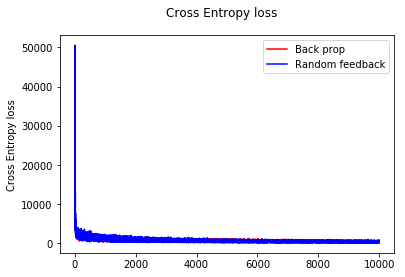

In [13]:
plt.plot(store_err_bp,'r',label='Back prop')
plt.plot(store_err_fa,'b',label='Random feedback')
plt.suptitle('Cross Entropy loss')
plt.ylabel('Cross Entropy loss')
plt.legend()
plt.show()

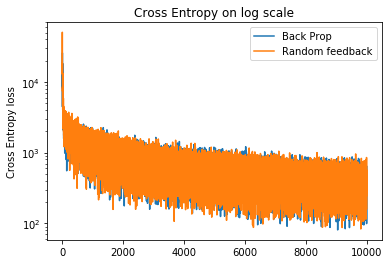

In [14]:
plt.semilogy(store_err_bp,label='Back Prop')
plt.semilogy(store_err_fa,label='Random feedback')
plt.title('Cross Entropy on log scale')
plt.ylabel('Cross Entropy loss')
plt.legend()`
plt.show()

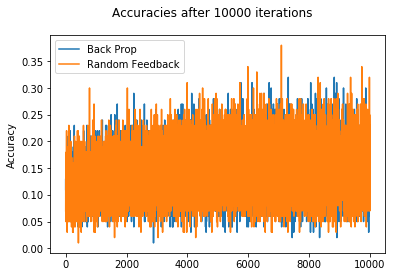

In [15]:
plt.plot(acc_bp,label='Back Prop')
plt.plot(acc_fa,label='Random Feedback')
plt.ylabel('Accuracy')
plt.suptitle("Accuracies after 10000 iterations")
plt.legend()
plt.show()

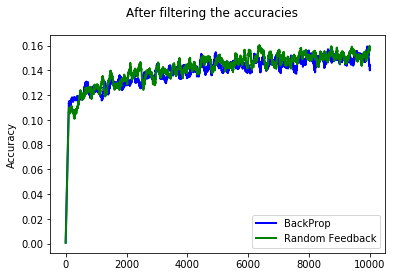

In [16]:
n = 100 # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1
yy_bp = lfilter(b,a,acc_bp)
yy_fa = lfilter(b,a,acc_fa)

plt.plot( yy_bp, linewidth=2, linestyle="-", c="b",label='BackProp')

plt.plot( yy_fa, linewidth=2, linestyle="-", c="g",label='Random Feedback')
plt.suptitle('After filtering the accuracies')
plt.legend()
plt.ylabel('Accuracy')
plt.show()